In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import scipy
import sklearn
from datetime import datetime
import locale
import time
from random import randint
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

In [44]:
pd.set_option('display.min_rows', 3500)

In [36]:
noise_data = pd.read_csv("Data/hourly_noisedata_2022.csv", header = 0, sep=',')
noise_data.head()

,month,day,hour,description,lamax,laeq,date,lamax_standardized,laeq_standardized
0,1,1,0,MP 03: Naamsestraat 62 Taste,60.322528,57.126833,00:00 01-01-2022,1.248969,1.044063
1,1,1,0,MP 05: Calvariekapel KU Leuven,53.230972,49.987639,00:00 01-01-2022,0.114661,-0.103638
2,1,1,0,MP 06: Parkstraat 2 La Filosovia,53.666056,50.752000,00:00 01-01-2022,0.184253,0.019241
3,1,1,0,MP 07: Naamsestraat 81,50.056861,47.440222,00:00 01-01-2022,-0.393044,-0.513162
4,1,1,1,MP 03: Naamsestraat 62 Taste,53.033583,50.853806,01:00 01-01-2022,0.083088,0.035608


In [37]:
noise_data = noise_data[noise_data["description"] == "MP 03: Naamsestraat 62 Taste"]
print(noise_data)
#Just location 3 for now

       month  day  hour                   description      lamax       laeq   
0          1    1     0  MP 03: Naamsestraat 62 Taste  60.322528  57.126833  \
4          1    1     1  MP 03: Naamsestraat 62 Taste  53.033583  50.853806   
8          1    1     2  MP 03: Naamsestraat 62 Taste  52.173702  50.049903   
12         1    1     3  MP 03: Naamsestraat 62 Taste  50.821311  48.964907   
16         1    1     4  MP 03: Naamsestraat 62 Taste  49.134851  47.285893   
...      ...  ...   ...                           ...        ...        ...   
55439     12   31    19  MP 03: Naamsestraat 62 Taste  55.340278  53.559333   
55445     12   31    20  MP 03: Naamsestraat 62 Taste  53.803528  52.055583   
55451     12   31    21  MP 03: Naamsestraat 62 Taste  52.387139  50.424556   
55457     12   31    22  MP 03: Naamsestraat 62 Taste  53.031611  51.030861   
55463     12   31    23  MP 03: Naamsestraat 62 Taste  59.199583  56.661017   

                   date  lamax_standardized  laeq_s

In [6]:
noise_month = noise_data[noise_data["month"] == 3]  
noise_day = noise_month[noise_month["day"] == 27]
len(noise_day)

23

In [8]:
weather_data = pd.read_csv("Data/hourly_weatherdata_2022.csv", header = 0, sep=',')
weather_data.head()

,Month,Day,Hour,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_TEMP_QCL3
0,1,1,0,0.000023,0.002997,-33.566358,1.487099,15.513391
1,1,1,1,0.000019,0.002174,-29.188272,1.465571,15.770757
2,1,1,2,0.000003,0.000360,-18.197324,0.389565,13.100358
3,1,1,3,0.000007,0.000000,-16.227891,0.222602,12.669197
4,1,1,4,0.000009,0.000000,-13.710884,0.217194,12.520271


In [66]:
hour_series = pd.Series(noise_data['hour'])
noise_series = pd.Series(noise_data['laeq'])
temp_series = pd.Series(weather_data['LC_TEMP_QCL3'])
rain_series = pd.Series(weather_data['LC_RAININ'])
rain_cumul_series = pd.Series(weather_data['LC_DAILYRAIN'])
windspeed_series = pd.Series(weather_data['LC_WINDSPEED'])
month = pd.Series(weather_data['Month'])
day = pd.Series(weather_data['Day'])
hour = pd.Series(weather_data['Hour'])

In [39]:
len(noise_series)

8759

In [11]:
len(temp_series)

8760

In [12]:
len(rain_series)

8760

In [67]:
#Forward impute single observation in noise series on March 27 2AM
noise_series.loc[9430] = 50.700694
noise_series = noise_series.sort_index()
noise_series = noise_series.reset_index().drop('index', axis = 1)

len(noise_series)

8760

In [11]:
#Day of week one hot encoding. Go for 24 hours, skip 144. Year starts on a saturday
lst = [6, 7, 1, 2, 3, 4, 5]
lst_new = list(np.repeat(lst,24))
lst_newnew = lst_new * 53
day = np.array(lst_newnew[0:8760])

weekday = pd.get_dummies(day, prefix=['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri'])


In [13]:
#Get holidays
holiday_df = pd.read_csv("Data/Holidays.csv", header = 0, sep=',')
holiday_list = holiday_df['Date'].tolist()

locale.setlocale(locale.LC_TIME, 'nl_NL')

formatted_holidays = []
for date_str in holiday_list:
    date_obj = datetime.strptime(date_str, "%d %b")
    formatted_holidays.append(date_obj)

formatted_holidays = [date_obj.strftime("%m-%d") for date_obj in formatted_holidays]
prefix = '2022-'
formatted_holidays = [prefix + i for i in formatted_holidays]


start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:59:59'
index = pd.date_range(start=start_date, end=end_date, freq='H')
df = pd.DataFrame(index=index)

df['Holiday'] = 0

for holiday in formatted_holidays:
    df.loc[holiday, 'Holiday'] = 1

holiday = pd.Series(df['Holiday'])
holiday_series = holiday.reset_index(drop = True)
len(holiday_series)

8760

In [15]:
#Combine into a feature matrix
features = pd.concat([hour, weekday, holiday_series, temp_series, rain_series, rain_cumul_series, windspeed_series], axis=1)
display(features)

,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,0,False,False,False,False,False,True,False,1,15.513391,0.000023,0.002997,1.487099
1,1,False,False,False,False,False,True,False,1,15.770757,0.000019,0.002174,1.465571
2,2,False,False,False,False,False,True,False,1,13.100358,0.000003,0.000360,0.389565
3,3,False,False,False,False,False,True,False,1,12.669197,0.000007,0.000000,0.222602
4,4,False,False,False,False,False,True,False,1,12.520271,0.000009,0.000000,0.217194
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,False,False,False,False,False,True,False,1,14.964675,0.000074,0.002981,1.200756
8756,20,False,False,False,False,False,True,False,1,15.006786,0.000077,0.002981,1.364861
8757,21,False,False,False,False,False,True,False,1,15.320673,0.000077,0.002988,1.473519
8758,22,False,False,False,False,False,True,False,1,15.483860,0.000074,0.002991,1.416481


In [29]:
#Keep only hours between 10pm and 6am
features['Hour'] = features['Hour'].astype('int')
nightfeatures = features[(features['Hour'] < 7) | (features['Hour'] > 21)]

hour_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 22: 7, 23: 8}
nightfeatures['Hour'] = nightfeatures['Hour'].replace(hour_mapping)
display(nightfeatures)

C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14844\3954957366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nightfeatures['Hour'] = nightfeatures['Hour'].replace(hour_mapping)


,Hour,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED
0,0,False,False,False,False,False,True,False,1,15.513391,0.000023,0.002997,1.487099
1,1,False,False,False,False,False,True,False,1,15.770757,0.000019,0.002174,1.465571
2,2,False,False,False,False,False,True,False,1,13.100358,0.000003,0.000360,0.389565
3,3,False,False,False,False,False,True,False,1,12.669197,0.000007,0.000000,0.222602
4,4,False,False,False,False,False,True,False,1,12.520271,0.000009,0.000000,0.217194
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8740,4,False,False,False,False,False,True,False,1,14.609157,0.000119,0.002687,1.580201
8741,5,False,False,False,False,False,True,False,1,14.425103,0.000096,0.002770,1.671420
8742,6,False,False,False,False,False,True,False,1,15.100726,0.000077,0.002778,1.855031
8758,7,False,False,False,False,False,True,False,1,15.483860,0.000074,0.002991,1.416481


In [30]:
#Trig encode night hours
nightfeatures['hour_sin'] = features['Hour'].apply(lambda x: math.sin(2*math.pi * x / 9))
nightfeatures['hour_cos'] = features['Hour'].apply(lambda x: math.cos(2*math.pi * x / 9))
nightfeatures = nightfeatures.drop('Hour', axis = 1)
display(nightfeatures)

C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14844\4273160610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nightfeatures['hour_sin'] = features['Hour'].apply(lambda x: math.sin(2*math.pi * x / 9))
C:\Users\Axl Wynants\AppData\Local\Temp\ipykernel_14844\4273160610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nightfeatures['hour_cos'] = features['Hour'].apply(lambda x: math.cos(2*math.pi * x / 9))


,"['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_2","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_3","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_4","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_5","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_6","['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_7",Holiday,LC_TEMP_QCL3,LC_RAININ,LC_DAILYRAIN,LC_WINDSPEED,hour_sin,hour_cos
0,False,False,False,False,False,True,False,1,15.513391,0.000023,0.002997,1.487099,0.000000,1.000000
1,False,False,False,False,False,True,False,1,15.770757,0.000019,0.002174,1.465571,0.642788,0.766044
2,False,False,False,False,False,True,False,1,13.100358,0.000003,0.000360,0.389565,0.984808,0.173648
3,False,False,False,False,False,True,False,1,12.669197,0.000007,0.000000,0.222602,0.866025,-0.500000
4,False,False,False,False,False,True,False,1,12.520271,0.000009,0.000000,0.217194,0.342020,-0.939693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8740,False,False,False,False,False,True,False,1,14.609157,0.000119,0.002687,1.580201,0.342020,-0.939693
8741,False,False,False,False,False,True,False,1,14.425103,0.000096,0.002770,1.671420,-0.342020,-0.939693
8742,False,False,False,False,False,True,False,1,15.100726,0.000077,0.002778,1.855031,-0.866025,-0.500000
8758,False,False,False,False,False,True,False,1,15.483860,0.000074,0.002991,1.416481,0.342020,-0.939693


In [69]:
#Get noise for only night hours 
noisedf = pd.concat([hour, noise_series], axis = 1)
noisedf = noisedf[(noisedf['Hour'] < 7) | (noisedf['Hour'] > 21)]

noise_seriesnight = noisedf['laeq']

display(noise_seriesnight)

0       57.126833
1       50.853806
2       50.049903
3       48.964907
4       47.285893
5       47.538650
6       46.146806
22      49.655333
23      47.838000
24      46.867665
25      45.862972
26      45.516667
27      45.024028
28      44.687306
29      45.059139
30      45.855639
46      51.335306
47      47.688056
48      46.224639
49      45.886306
50      45.069417
51      44.824250
52      45.137583
53      45.702611
54      50.850139
70      50.393889
71      48.737861
72      47.744139
73      45.822333
74      44.730639
          ...    
8670    48.276750
8686    50.843056
8687    49.844111
8688    50.118194
8689    47.425306
8690    47.953639
8691    49.330694
8692    51.009278
8693    45.238028
8694    46.914583
8710    51.478472
8711    49.786667
8712    49.375417
8713    46.895556
8714    46.471111
8715    46.803417
8716    46.736778
8717    46.275188
8718    48.119639
8734    61.241889
8735    51.172056
8736    49.278472
8737    49.766722
8738    47.275000
8739    46

In [70]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(nightfeatures, noise_seriesnight,
    test_size=0.2)

#Convert target variables to 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [71]:
#Random forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [72]:
#Random forest evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 5.204190648749999
Mean Absolute Error (MAE): 1.8214994177670143
R-squared Score (R2): 0.49011156685558177


In [74]:
#Try randomized search to save on computation time
start_time = time.time()
param_dist = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000],  # Number of trees in the forest
    'max_features': [1.0, 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None] + list(range(5, 30, 5)), #Maximum depth of the trees
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Minimum number of samples required to be at a leaf node 
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    verbose=1
)

random_search.fit(X_train, y_train)
bestr_model = random_search.best_estimator_
best_params = random_search.best_params_

end_time = time.time()
elapsed_time = end_time - start_time

print(best_params)
#Best parameters {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 15}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 15}


In [75]:
print("Time it took to train: {:.2f} seconds".format(elapsed_time))

Time it took to train: 781.80 seconds


In [77]:
#So this cell is the random search-tuned model with its final hyperparameters
finalmodel = RandomForestRegressor()
bestparams = {'n_estimators': 400, 'min_samples_split': 3, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 1.0}
finalmodel.set_params(**bestparams)
finalmodel.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_split=3, n_estimators=400)

In [78]:
#Evaluating randomized search-tuned model
predictions2 = finalmodel.predict(X_test)

mse = mean_squared_error(y_test, predictions2)
mae = mean_absolute_error(y_test, predictions2)
r2 = r2_score(y_test, predictions2)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)

Mean Squared Error (MSE): 5.369558657219115
Mean Absolute Error (MAE): 1.8474850548650354
R-squared Score (R2): 0.47390938664706395


Elapsed time to compute the importances: 15.421 seconds


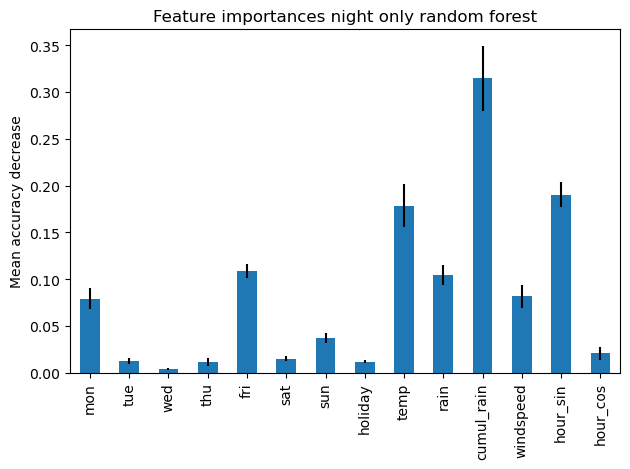

In [79]:
start_time = time.time()
result = permutation_importance(
    finalmodel, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'holiday', 
                                                               'temp', 'rain', 'cumul_rain', 'windspeed', 'hour_sin', 'hour_cos'])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances night only random forest")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()